Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/GP_try/try


In [3]:
import sys; sys.path.append('../')

import torch
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
from feature_extractor import FeatureExtractor
import numpy as np
import time
from cascade import CascadeClassifier
import os
from PIL import Image
from typing import List, Tuple
import pickle as pkl

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def get_subwindows(img: torch.Tensor or np.ndarray, size: Tuple, stride: int, device: torch.device):
    """
    img: torch.Tensor, shape = 
        (height, width) for a single image (GRAY),
        (n_channels, height, width) for a single image (RGB),
        (n_images, n_channels, height, width) for multiple images (RGB or GRAY)

        or np.ndarray, shape =
        (height, width) for a single image (GRAY),
        (height, width, n_channels) for a single image (RGB),
        (n_images, height, width, n_channels) for multiple images (RGB or GRAY)

    size: tuple, (wnd_h, wnd_w) window size
    stride: int, stride

    return: subwindows (torch.Tensor), shape = (n_images, n_subwindows, n_channels, wnd_h, wnd_w)
    """
    if isinstance(img, np.ndarray):
        if len(img.shape) == 4:
            img = torch.tensor(img, device=device).float().permute(0, 3, 1, 2) # (n_images, n_channels, height, width)
        if len(img.shape) == 3:
            img = torch.tensor(img, device=device).float().permute(2, 0, 1) # (n_channels, height, width)
        elif len(img.shape) == 2:
            img = torch.tensor(img).float()
    
    
    wnd_h, wnd_w = size
    if len(img.shape) == 2: # single image, GRAY: (height, width)
        img = img.unsqueeze(0)

    if len(img.shape) == 3: # single image, RGB: (n_channels, height, width)
        img = img.unsqueeze(0)  # add batch dimension

    n_channels = img.shape[1]
    n_images = img.shape[0]
    height = img.shape[-2]
    width = img.shape[-1]

    # get subwindows
    subwindows = img.unfold(2, wnd_h, stride).unfold(3, wnd_w, stride) # (n_images, n_channels, n_subwindows_h, n_subwindows_w, wnd_h, wnd_w)
    subwindows = subwindows.permute(0, 2, 3, 1, 4, 5) # (n_images, n_subwindows_h, n_subwindows_w, n_channels, wnd_h, wnd_w)
    subwindows = subwindows.reshape(n_images, -1, n_channels, wnd_h, wnd_w) # (n_images, n_subwindows, n_channels, wnd_h, wnd_w)

    # get subwindows' coordinates
    x = torch.arange(0, width - wnd_w + 1, stride)
    y = torch.arange(0, height - wnd_h + 1, stride)
    x, y = torch.meshgrid(x, y)
    x = x.reshape(-1)
    y = y.reshape(-1)
    coordinates = torch.stack((x, y), dim=1)  # (n_subwindows, 2)

    return subwindows, coordinates

In [7]:
parent = '../../lfw_all/'

In [8]:
trained_parent = '../hFeatures/'

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# !cp /content/drive/MyDrive/GP/hFeatures/* ../hFeatures

In [15]:
# !mkdir ../../lfw_all
# !cp /content/drive/MyDrive/GP/lfw_all/* ../../lfw_all/

In [13]:
all_images_names = os.listdir(parent)
# all_images_names = sorted(all_images_names)
import random
random.shuffle(all_images_names)
all_images_names = [parent + name for name in all_images_names]
all_images_names[0]

'../../lfw_all/Gerhard_Schroeder_0062.jpg'

RGB
(250, 250, 3)


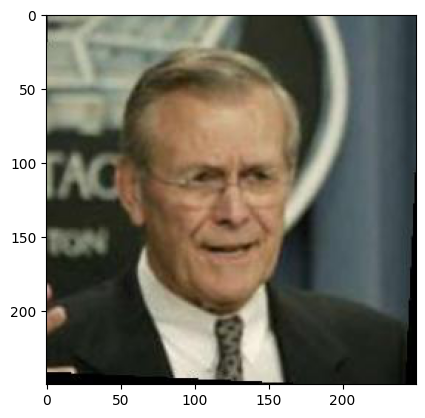

In [14]:
# show image
img = Image.open(all_images_names[1])
# check it is a RGB image
print(img.mode)

img = np.array(img)

print(img.shape)
plt.imshow(img)
plt.show()


(250, 250)
subwindows.shape:  torch.Size([1, 16, 1, 100, 100])


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


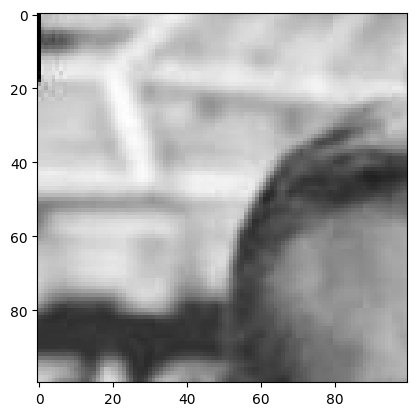

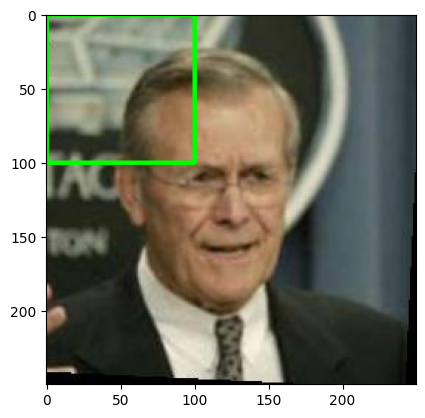

coordinates:  tensor([0, 0])


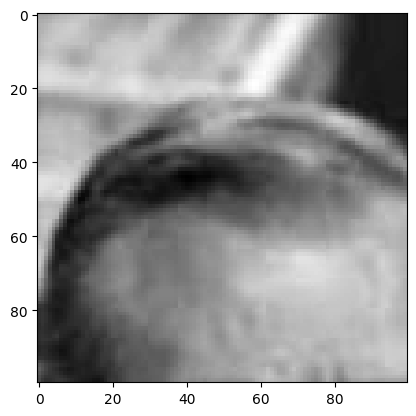

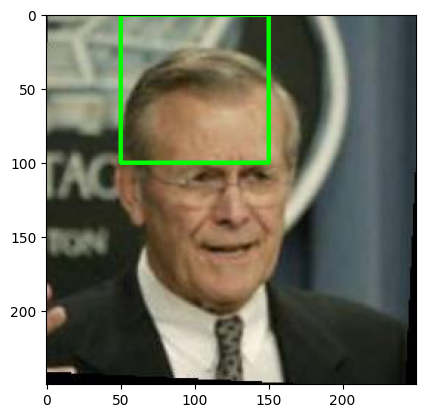

coordinates:  tensor([ 0, 50])


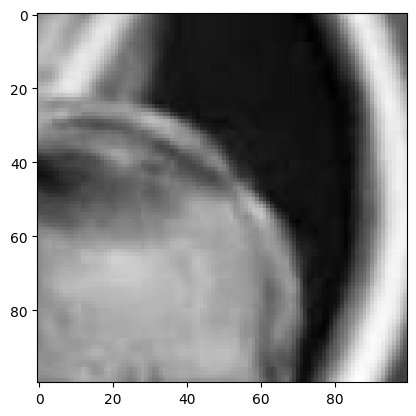

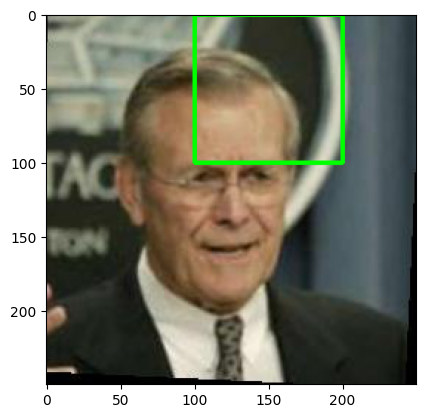

coordinates:  tensor([  0, 100])


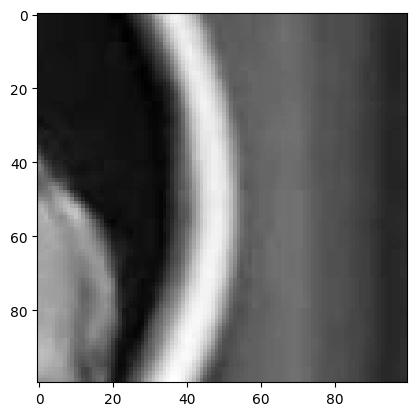

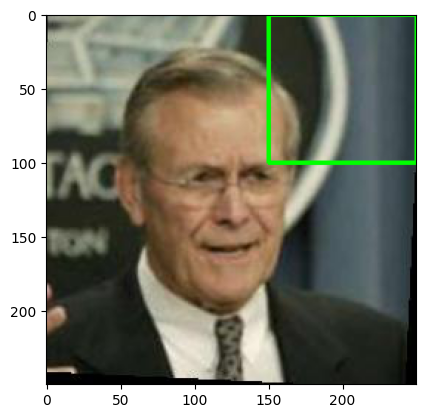

coordinates:  tensor([  0, 150])


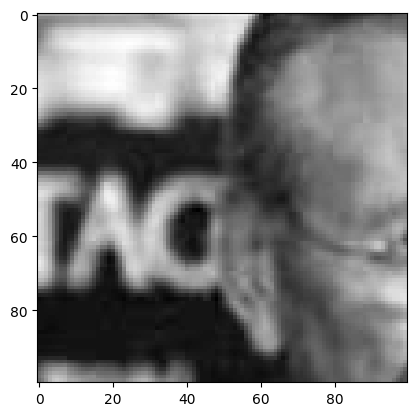

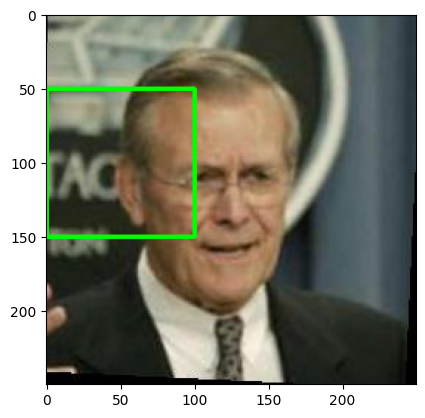

coordinates:  tensor([50,  0])


In [15]:
# get subwindows
# to gray
img2 = img

img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img2.shape)

# img2 = torch.tensor(img2).float().permute(2, 0, 1) if len(img2.shape) == 3 else torch.tensor(img2).float()

# get subwindows
window_size = (19, 19)
stride = 10

window_size = (100, 100)
stride = 50

# window_size = (img2.shape[0], img2.shape[1])

subwindows, coordinates = get_subwindows(img2, window_size, stride, device)
print("subwindows.shape: ", subwindows.shape)
# show subwindows
def show_subwindows(subwindows, coordinates, maximum=np.inf, window_size=(100, 100), showRect=True):
    subwindows = subwindows[0]
    for i in range(0, min(maximum, subwindows.shape[0])):
        tmp_img = subwindows[i].int().permute(1, 2, 0) # (height, width, n_channels)
        tmp_img = tmp_img.cpu().numpy().astype(np.uint8) if isinstance(tmp_img, torch.Tensor) else tmp_img.astype(np.uint8)
        plt.imshow(tmp_img, cmap='gray' if tmp_img.shape[-1] == 1 else None)
        plt.show()

        if  showRect:
            tmp_img2 = img.copy()
            y, x = coordinates[i]
            x = int(x)
            y = int(y)
            cv2.rectangle(tmp_img2, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)
            plt.imshow(tmp_img2, cmap='gray' if len(tmp_img2.shape) == 2 else None)
            plt.show()
            
        print("coordinates: ", coordinates[i])

show_subwindows(subwindows, coordinates, maximum=5, window_size=window_size)

In [16]:
feature_extractor = FeatureExtractor(shape=(19,19), 
                                     percentile=20,
                                     all_features_file=trained_parent + "all_features.npz",
                                     selected_features_file=trained_parent + "selected_features.npz",
                                     labels_file=trained_parent + "labels.npy",
                                     indecies_file=trained_parent + "indecies.npy",
                                     verbose=False)
indecies, X = feature_extractor.selectPercentile()

In [17]:
cascadeClassifier = pkl.load(open(trained_parent + "cascadeClassifier.pkl", "rb"))

In [25]:
# Path to the directory containing the images
dir_path = "../new_data3/test/non-face/"

# Get a list of all the image file paths in the directory
non_face_image_paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]

# Read the first image
image = Image.open(non_face_image_paths[1])

# Convert the image to a numpy array
image_array = np.array(image)

# Print the min, max, mean, and std of the pixel values
print("Min:", np.min(image_array))
print("Max:", np.max(image_array))
print("Mean:", np.mean(image_array))
print("Std:", np.std(image_array))

image.show()

FileNotFoundError: ignored

In [35]:
def find_face(img: np.ndarray, 
              classifier:CascadeClassifier, 
              feature_extractor:FeatureExtractor,
              window_size:Tuple=(19,19), 
              scale_dist:float=1.25, 
              max_size:int=300, 
              stride:int=10, 
              device:torch.device=None,
              verbose:bool=False):
    """
    img: np.ndarray, shape = (height, width) (should be normalized, resized to same size, and gray)
    window_size: tuple, (wnd_h, wnd_w) window size used for training 
    scale_dist: float, scale distance between two scales
    max_size: int, max size of the image
    stride: int, stride
    classifier: CascadeClassifier, classifier
    feature_extractor: FeatureExtractor, feature extractor
    device: torch.device, device

    return: face_coordinates: list of tuples, [(x1, y1, x2, y2), ...] (x1, y1) is the top left corner, (x2, y2) is the bottom right corner
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # img =  (img - img.mean()) / img.std()
    # get subwindows
    current_size = window_size[0], window_size[1]
    max_confidence = -np.inf
    region_max_conf = None
    face_coordinates = []
    while current_size[0] < max_size and current_size[1] < max_size and current_size[0] < img.shape[0] and current_size[1] < img.shape[1]:
        if verbose:
            print("current_size: ", current_size)

        subwindows, coordinates = get_subwindows(img, current_size, stride, device)
        # get rid of n_channels dimension as it is 1
        subwindows = subwindows.squeeze(2) # (n_images, n_subwindows, wnd_h, wnd_w)
        orig_sh = subwindows.shape # (n_images, n_subwindows, n_channels, wnd_h, wnd_w)


        # Resize subwindows to window_size 
        # TODO: instead of resizing images: resize features
        # subwindows = subwindows.reshape(-1, orig_sh[-3], orig_sh[-2], orig_sh[-1]) # (n_images * n_subwindows, n_channels, wnd_h, wnd_w)
        # subwindows = F.interpolate(subwindows, size=window_size, mode='bilinear', align_corners=False) # (n_images, n_subwindows, n_channels, wnd_h, wnd_w)
        # subwindows = subwindows.reshape(orig_sh[0], orig_sh[1], orig_sh[2], window_size[0], window_size[1]) # (n_images, n_subwindows, n_channels, wnd_h, wnd_w)
        
        subwindows = subwindows.reshape(-1, orig_sh[-2], orig_sh[-1]) # (n_images * n_subwindows, wnd_h, wnd_w)
        subwindows = F.interpolate(subwindows.unsqueeze(1), size=window_size, mode='bilinear', align_corners=False) # (n_images * n_subwindows, 1, wnd_h, wnd_w)
        # unsqueeze(1) is needed because F.interpolate needs 4D tensor of shape (n_images, n_channels, height, width)
        subwindows = subwindows.squeeze(1) # (n_images * n_subwindows, wnd_h, wnd_w)     
        # Calculate mean and standard deviation of pixel values along axis 0
        mean = subwindows.mean(dim=0, keepdim=True)
        std = subwindows.std(dim=0, keepdim=True)

        # Normalize pixel values of each image using mean and std
        # subwindows = (subwindows - mean) / std
        # for subwindow in subwindows:
        #   print(subwindow.shape)
        #   plt.imshow(subwindow, cmap='gray')
        #   plt.show()
        # subwindows = subwindows.reshape(orig_sh[0], orig_sh[1], window_size[0], window_size[1]) # (n_images, n_subwindows, wnd_h, wnd_w)   

        if verbose:
            print("subwindows.shape: ", subwindows.shape)
            print("subwindows.shape: ", subwindows.shape)
            print("coordinates.shape: ", coordinates.shape)
        
        t_f_idx_map, t_features = feature_extractor.extractFeaturesFromImage(subwindows,
                                                cascadeClassifier=classifier)
        
        
        if verbose:
            print("t_features.shape: ", t_features.shape)
            print("t_f_idx_map: ", t_f_idx_map)

        # Predict
        predictions = classifier.predict(t_features, t_f_idx_map)

        if verbose:
            print("predictions.shape: ", predictions.shape)
            print("predictions: ", predictions)

        # get face coordinates from coordinates, predictions. Put coordinates, size into face_coordinates
        # make 4 coordinates for each face (x1, y1, x2, y2)
        tmp_conf = cascadeClassifier.confidence(t_features, t_f_idx_map)
        arg_max = np.argmax(tmp_conf)
        if tmp_conf[arg_max] > max_confidence:
          # region_max_conf = np.concatenate((coordinates[arg_max], coordinates[arg_max] + np.array(window_size)), axis=0)
          region_max_conf = np.concatenate((coordinates[arg_max], coordinates[arg_max] + np.array(current_size)), axis=0)
          max_confidence = tmp_conf[arg_max]

        # tmp_tuple = np.concatenate((coordinates[predictions == 1], coordinates[predictions == 1] + torch.tensor(window_size)), axis=1)
        tmp_tuple = np.concatenate((coordinates[predictions == 1], coordinates[predictions == 1] + torch.tensor(current_size)), axis=1)
        face_coordinates.append(tmp_tuple)


        if verbose:
            print("face_coordinates.shape: ", np.array(face_coordinates).shape)
            print("face_coordinates: ", np.array(face_coordinates))

        current_size = int(current_size[0] * scale_dist), int(current_size[1] * scale_dist)

    return face_coordinates, region_max_conf, max_confidence

In [55]:
show_images = list(range(0, 20))
rectangles_only = True
random.shuffle(all_images_names)

In [56]:
for i in show_images:
  img = Image.open(all_images_names[i])
  print(img.mode)
  img = np.array(img)
  print(img.shape)
  if not rectangles_only:
    plt.imshow(img)
    plt.show()
  # get subwindows
  img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print(img2.shape)

  # normalize image
  img2 = (img2 - img2.mean()) / img2.std()

  img2 = cv2.normalize(img2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  # resize image
  # img2 = cv2.resize(img2, (570, 380))

  # show image
  if not rectangles_only:
    plt.imshow(img2, cmap='gray')
    plt.show()

  # +++++++++++++++++++++
  # find face
  
  face_coordinates, region_max_conf, max_conf =\
                  find_face(img2, \
                              cascadeClassifier, \
                              feature_extractor, \
                              window_size=(19, 19), \
                              scale_dist=1.1, \
                              max_size=300, \
                              stride=5, \
                              device=device, \
                              verbose=False)


  # ++++++++++++++++++++
  # rectangles 
  tmp_img = img.copy()
  for face_coordinate in face_coordinates:
      for x1, y1, x2, y2 in face_coordinate:
          cv2.rectangle(tmp_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
  # if not rectangles_only:          
  plt.imshow(tmp_img)
  plt.show()

  # amx confidence
  tmp_img = img.copy()
  x1, y1, x2, y2 = region_max_conf
  cv2.rectangle(tmp_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
  plt.imshow(tmp_img)
  plt.show()



Output hidden; open in https://colab.research.google.com to view.